# Cross-validation of the Ishigami model

In this example, we show how to perform the cross-validation of the Ishigami model using polynomial chaos expansion. More precisely, we use the methods suggested in [Müller & Guido, 2016], chapter 5, page 257. We make the assumption that a dataset is given and we create a metamodel using this data. Once done, we want to assess the quality of the metamodel using the data we have. 

We compare several methods:
- split the data into two subsets, one for training and one for testing,
- use k-fold validation.

The split of the data is performed by the `compute_Q2_score_by_splitting` function below. It uses 75% of the data to estimate the coefficients of the metamodel (this is the training step) and use 25% of the data to estimate the $Q^2$ score (this is the validation step). To do this, we use the `split` method of the `Sample`. 

The K-Fold validation is performed by the `compute_Q2_score_by_kfold` function below. It uses the K-Fold method with $k = 5$. The code uses the `KFoldSplitter` class, which computes the appropriate indices. 

This cross-validation method is used here to see which polynomial degree leads to an accurate metamodel of the Ishigami test function.

## References
- Müller, A. C., & Guido, S. (2016). Introduction to machine learning with Python: a guide for data scientists. " O'Reilly Media, Inc.".

In [1]:
import openturns as ot
import openturns.viewer as otv
import pylab as pl

from openturns.usecases import ishigami_function as ishigami_function

In [2]:
execute_fast = True  # Set to False for real simulations

In [3]:
def compute_sparse_least_squares_chaos(
    inputTrain, outputTrain, multivariateBasis, totalDegree, myDistribution
):
    """
    Create a sparse polynomial chaos based on least squares.

    * Uses the enumerate rule in multivariateBasis.
    * Uses the LeastSquaresStrategy to compute the coefficients based on
      least squares.
    * Uses LeastSquaresMetaModelSelectionFactory to use the LARS selection method.
    * Uses FixedStrategy in order to keep all the coefficients that the
      LARS method selected.

    Parameters
    ----------
    inputTrain : ot.Sample
        The input design of experiments.
    outputTrain : ot.Sample
        The output design of experiments.
    multivariateBasis : ot.Basis
        The multivariate chaos basis.
    totalDegree : int
        The total degree of the chaos polynomial.
    myDistribution : ot.Distribution.
        The distribution of the input variable.
    Returns
    -------
    result : ot.PolynomialChaosResult
        The estimated polynomial chaos.
    """
    selectionAlgorithm = ot.LeastSquaresMetaModelSelectionFactory()
    projectionStrategy = ot.LeastSquaresStrategy(
        inputTrain, outputTrain, selectionAlgorithm
    )
    enumfunc = multivariateBasis.getEnumerateFunction()
    P = enumfunc.getStrataCumulatedCardinal(totalDegree)
    adaptiveStrategy = ot.FixedStrategy(multivariateBasis, P)
    chaosalgo = ot.FunctionalChaosAlgorithm(
        inputTrain, outputTrain, myDistribution, adaptiveStrategy, projectionStrategy
    )
    chaosalgo.run()
    result = chaosalgo.getResult()
    return result


def compute_Q2_score_by_splitting(
    X_dataset,
    Y_dataset,
    multivariateBasis,
    totalDegree,
    myDistribution,
    split_fraction=0.75,
):
    """
    Compute Q2 score by splitting into train/test sets.
    Parameters
    ----------
    X_dataset : ot.Sample(size, input_dimension)
        The X dataset.
    Y_dataset : ot.Sample(size, output_dimension)
        The Y dataset.
    Returns
    -------
    Q2_score : float
        The Q2 score.
    """

    training_sample_size = X_dataset.getSize()
    X_train = ot.Sample(X_dataset)
    Y_train = ot.Sample(Y_dataset)
    split_index = int(split_fraction * training_sample_size)
    X_test = X_train.split(split_index)
    Y_test = Y_train.split(split_index)
    result = compute_sparse_least_squares_chaos(
        X_train, Y_train, multivariateBasis, totalDegree, myDistribution
    )
    metamodel = result.getMetaModel()
    val = ot.MetaModelValidation(X_test, Y_test, metamodel)
    Q2_score = val.computePredictivityFactor()[0]
    return Q2_score


def compute_Q2_score_by_kfold(
    X_dataset,
    Y_dataset,
    multivariateBasis,
    totalDegree,
    myDistribution,
    number_of_folds=5,
):
    """
    Compute score by KFold.
    Parameters
    ----------
    X_dataset : ot.Sample(size, input_dimension)
        The X dataset.
    Y_dataset : ot.Sample(size, output_dimension)
        The Y dataset.
    Returns
    -------
    Q2_score : float
        The Q2 score.
    """
    #
    training_sample_size = X_dataset.getSize()
    splitter = ot.KFoldSplitter(training_sample_size, number_of_folds)
    Q2_score_list = ot.Sample(0, 1)
    for indices1, indices2 in splitter:
        X_train, X_test = X_dataset[indices1], X_dataset[indices2]
        Y_train, Y_test = Y_dataset[indices1], Y_dataset[indices2]
        result = compute_sparse_least_squares_chaos(
            X_train, Y_train, multivariateBasis, totalDegree, myDistribution
        )
        metamodel = result.getMetaModel()
        val = ot.MetaModelValidation(X_test, Y_test, metamodel)
        Q2_local = val.computePredictivityFactor()[0]
        Q2_score_list.add([Q2_local])
    Q2_score = Q2_score_list.computeMean()[0]
    return Q2_score

We start by generating the input and output sample. We use a sample size equal to 1000. 

In [4]:
im = ishigami_function.IshigamiModel()

im.distributionX.setDescription(["$X_0$", "$X_1$", "$X_2$"])
im.model.setOutputDescription(["$Y$"])

sample_size = 1000
X_dataset = im.distributionX.getSample(sample_size)
print("Input sample:")
print(X_dataset[:5])
Y_dataset = im.model(X_dataset)
Y_dataset.setDescription(["$Y$"])
print("Output sample:")
print(Y_dataset[:5])

Input sample:
    [ $X_0$     $X_1$     $X_2$     ]
0 : [  0.816038  2.67553   0.501506 ]
1 : [  2.40524  -2.19212  -0.705186 ]
2 : [ -2.29163   1.30032  -1.41281  ]
3 : [ -2.93737  -0.733649  2.30831  ]
4 : [ -0.960969 -0.43361  -2.39129  ]
Output sample:
    [ $Y$      ]
0 : [  2.14659 ]
1 : [  5.31621 ]
2 : [  5.44969 ]
3 : [  2.35982 ]
4 : [ -2.26455 ]


## Create a metamodel

We compute a polynomial chaos decomposition with a total degree equal to 5. In order to reduce the number of coefficients, we create a sparse chaos using regression and the LARS. 

In [5]:
dimension = im.distributionX.getDimension()
multivariateBasis = ot.OrthogonalProductPolynomialFactory(
    [im.distributionX.getMarginal(i) for i in range(dimension)]
)

totalDegree = 5  # Polynomial degree
result = compute_sparse_least_squares_chaos(
    X_dataset, Y_dataset, multivariateBasis, totalDegree, im.distributionX
)
metamodel = result.getMetaModel()

## Validation

In order to validate our polynomial chaos, we generate an extra pair of input / output samples and use the `MetaModelValidation` class. 

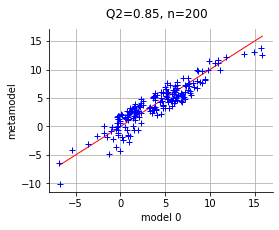

In [6]:
test_sample_size = 200  # Size of the validation design of experiments
inputTest = im.distributionX.getSample(test_sample_size)
outputTest = im.model(inputTest)
validation = ot.MetaModelValidation(inputTest, outputTest, metamodel)
Q2 = validation.computePredictivityFactor()[0]
graph = validation.drawValidation()
graph.setTitle("Q2=%.2f, n=%d" % (Q2, test_sample_size))
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

The plot shows that the score is relatively high and might be satisfactory for some purposes. There are however several issues with the previous procedure.

- It may happen that the data in the validation sample with size 200 is more difficult to fit than the data in the training dataset. In this case, the $Q^2$ score may be pessimistic. 
- It may happen that the data in the 1000 validation sample with size 200 is less difficult to fit than the data in the validation dataset. In this case, the $Q^2$ score may be optimistic. 
- We may not be able to generate an extra dataset for validation. In this case, a part of the original dataset should be used for validation.
- The polynomial degree may not be appropriate for this data. 
- The dataset may be ordered in some way, so that the split is somewhat arbitrary. One solution to circumvent this is to randomly shuffle the data.

The K-Fold validation aims at solving some of these issues, so that all the available data is used in order to estimate the $Q^2$ score. 

## Cross-validation

In the following script, we compute the $Q^2$ score associated with each polynomial degree from 1 to 10. 

In [7]:
if execute_fast:
    degree_max = 4
else:
    degree_max = 10
degree_list = list(range(1, degree_max))
number_of_degrees = len(degree_list)
score_sample = ot.Sample(len(degree_list), 1)
for i in range(number_of_degrees):
    totalDegree = degree_list[i]
    score_sample[i, 0] = compute_Q2_score_by_splitting(
        X_dataset, Y_dataset, multivariateBasis, totalDegree, im.distributionX
    )
    print("Degree = %d, Score = %.4f" % (totalDegree, score_sample[i, 0]))

Degree = 1, Score = 0.2099
Degree = 2, Score = 0.2400
Degree = 3, Score = 0.4943
Degree = 4, Score = 0.7599
Degree = 5, Score = 0.8438
Degree = 6, Score = 0.9777
Degree = 7, Score = 0.9903
Degree = 8, Score = 0.9996
Degree = 9, Score = 0.9998


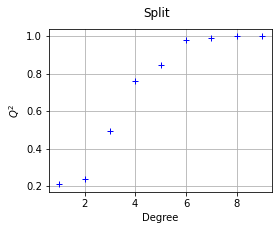

In [8]:
graph = ot.Graph("Split", "Degree", "$Q^2$", True)
cloud = ot.Cloud(ot.Sample.BuildFromPoint(degree_list), score_sample)
graph.add(cloud)
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

We see that the polynomial degree may be increased up to degree 7, after which the $Q^2$ score does not increase much. 

One limitation of the previous method is that the estimate of the $Q^2$ may be sensitive to the particular split of the dataset. The following script uses 5-Fold cross validation to estimate the $Q^2$ score.

In [9]:
score_sample = ot.Sample(len(degree_list), 1)
for i in range(number_of_degrees):
    totalDegree = degree_list[i]
    score_sample[i, 0] = compute_Q2_score_by_kfold(
        X_dataset, Y_dataset, multivariateBasis, totalDegree, im.distributionX
    )
    print("Degree = %d, Score = %.4f" % (totalDegree, score_sample[i, 0]))

Degree = 1, Score = 0.1836
Degree = 2, Score = 0.2017
Degree = 3, Score = 0.4549
Degree = 4, Score = 0.7208
Degree = 5, Score = 0.8423
Degree = 6, Score = 0.9783
Degree = 7, Score = 0.9904
Degree = 8, Score = 0.9996
Degree = 9, Score = 0.9998


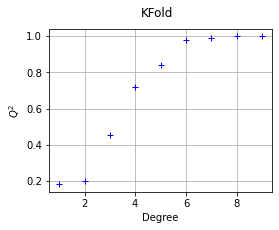

In [10]:
graph = ot.Graph("KFold", "Degree", "$Q^2$", True)
cloud = ot.Cloud(ot.Sample.BuildFromPoint(degree_list), score_sample)
graph.add(cloud)
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

The conclusion is similar to the previous method.

When we select the best polynomial degree which maximizes the $Q^2$ score, the danger is that the validation set is used both for computing the $Q^2$ and to maximize it: hence, the $Q^2$ score may be optimistic. In [Müller & Guido, 2016], chapter 5, page 269, the authors advocate the split of the dataset into three subsets:

- the training set,
- the validation set,
- the test set.

When selecting the best parameters, the validation set is used. When estimating the $Q^2$ score with the best parameters, the test set is used. 